# Machine Learning (Scikit Learn and Yellow Brick)

# Notebook set-up

In [395]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import io
import pickle
import statistics as stat
import statsmodels.api as sm
from statsmodels.api import OLS
import random
from sklearn import cross_validation as cv
import statsmodels.formula.api as smf
import scipy as sp
from sklearn.metrics import classification_report
import scipy.stats
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from pandas.tools.plotting import scatter_matrix, radviz
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

sns.set_style('whitegrid')
sns.set_context('notebook')

# Data loading

In [396]:
# Load the data into a dataframe 
#can_master = pd.read_csv('can-1996-2016.csv')
#cmte_master =pd.read_csv('cm-1996-2014.csv') 
#opex=pd.read_csv('opex-2004-2014.csv')
#oth=pd.read_csv('oth-1996-2014.csv')
#exp=pd.read_csv('expresults_rev.csv')
#election_spend=pd.read_csv('catall.csv')
#results = pd.read_csv('candr.csv')
#catsort= pd.read_csv('catsort_rev.csv')
cost_vote = pd.read_csv('combined_all.csv')

In [397]:
cost_vote['total_votes']=cost_vote['total_votes'].fillna(0)
cost_vote['totalspend']=cost_vote['totalspend'].fillna(0)
cost_vote['incumbent']=cost_vote['incumbent'].fillna(0)
cost_vote['party']=cost_vote['party'].fillna('None')
cost_vote = cost_vote.drop(['costpervote'], axis=1)
cost_vote['totalspend']=pd.to_numeric(cost_vote['totalspend'],errors='coerce')
print(cost_vote[pd.to_numeric(cost_vote['totalspend'], errors = 'coerce').isnull()])
cost_vote['total_votes']=pd.to_numeric(cost_vote['total_votes'],errors='coerce')
print(cost_vote[pd.to_numeric(cost_vote['total_votes'], errors = 'coerce').isnull()])
cost_vote['cycle']=pd.to_numeric(cost_vote['cycle'],errors='coerce')
print(cost_vote[pd.to_numeric(cost_vote['cycle'], errors = 'coerce').isnull()])
cost_vote = cost_vote[cost_vote.total_votes != 0]
cost_vote.loc[cost_vote['totalspend'] == 0]
cost_vote = cost_vote.rename(columns = {'ge_winner_indicator':'winner'})
cost_vote['costvote'] = cost_vote['totalspend']/cost_vote['total_votes']
cost_vote['cycle'] = cost_vote['cycle'].astype(int).astype('str')
cost_vote['party'] = cost_vote['party'].astype('str')
cost_vote = cost_vote.replace("DEM","D")
cost_vote = cost_vote.replace("DEM ","D")
cost_vote = cost_vote.replace("REP","R")
cost_vote = cost_vote.replace("REP ","R")
Republican = cost_vote[cost_vote['party'] == "R"]
Democrat = cost_vote[cost_vote['party'] == "D"]

Empty DataFrame
Columns: [cand_id, cycle, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, state_abbreviation, district, incumbent, party, primary_votes, runoff_votes, general_votes, ge_runoff_election_votes, ge_winner_indicator, total_votes, totalspend]
Index: []

[0 rows x 26 columns]
Empty DataFrame
Columns: [cand_id, cycle, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, state_abbreviation, district, incumbent, party, primary_votes, runoff_votes, general_votes, ge_runoff_election_votes, ge_winner_indicator, total_votes, totalspend]
Index: []

[0 rows x 26 columns]
Empty DataFrame
Columns: [cand_id, cycle, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, state_abbreviation, district, incumbent, party, primary_votes, runoff_votes, general_votes, ge_runoff_election_votes, ge_winner_indicator, total_votes, totalspend]
Index: []

[0 rows x 26 columns]


In [398]:
testframes = [Republican, Democrat]
result = pd.concat(testframes)
Gen = result

In [399]:
Gen = Gen.replace("W (Runoff)","0")
Gen = Gen.replace("WW","0")
Gen = Gen.replace("Dd","0")

In [400]:
Gen['race'] = Gen['cand_id'].astype(str).str[0]

In [401]:
Gen = Gen[Gen['race'] == "H"]

In [402]:
#All winners of election
Winner = Gen[Gen['winner'].isin(['1'])]

In [403]:
#All losers of election
Loser = Gen[Gen['winner'].isin(['0'])]

In [404]:
Dem = Gen[Gen['party'].isin(['D'])]

In [405]:
#All Democrat Winners
DemW = Dem[Dem['winner'].isin(['1'])] 

In [406]:
#All democrat incumbent winners
DemWInc = DemW[DemW['incumbent'].isin(['1'])] #table of Democrat Incumbent who won

In [407]:
#All democrat challengesr who won
DemWC = DemW[DemW['incumbent'].isin(['0'])] 

In [408]:
DemL = Dem[Dem['winner'].isin(['0'])] #table of Democrats who lost

In [409]:
DemLInc = DemL[DemL['incumbent'].isin(['1'])] #table of Democrat Incumbent who lost

In [410]:
DemLC = DemL[DemL['incumbent'].isin(['0'])] #table of Democrat challengers who lost

In [411]:
Rep = Gen[Gen['party'].isin(['R'])] #republicans

In [412]:
#all republican winners
RepW = Rep[Rep['winner'].isin(['1'])]

In [413]:
#all republican incumbents
RepWInc = RepW[RepW['incumbent'].isin(['1'])]

In [414]:
#all republican challengers
RepWC = Rep[Rep['incumbent'].isin(['0'])]

In [415]:
#all republican losers
RepL = Rep[Rep['winner'].isin(['0'])]

In [416]:
#all republican incumbent who lost
RepLInc = RepL[RepL['incumbent'].isin(['1'])]

In [417]:
#all republican challengers who lost
RepLC = RepL[RepL['incumbent'].isin(['0'])]

# machine learning Regression

In [418]:
#define features
feature_cols = ['c1', 'c2','c3', 'c4','c5','c6','c7','c8','c9','c10','c11','c12','c13']

# Features of Republican Winners
X = RepW[feature_cols]

In [419]:
print (type(X))
print (X.shape)

<class 'pandas.core.frame.DataFrame'>
(1274, 13)


In [420]:
# defining the dependent
y = RepW['total_votes']

In [421]:
print (type(y))
print (y.shape)

<class 'pandas.core.series.Series'>
(1274,)


In [422]:
#checking X and y shapes
X.shape, y.shape

((1274, 13), (1274,))

In [423]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.4, random_state = 0)

In [424]:
X_train.shape, y_train.shape

((764, 13), (764,))

In [425]:
X_test.shape, y_test.shape

((510, 13), (510,))

In [449]:
from sklearn.linear_model import LinearRegression

# Fit regression to diabetes dataset
model = LinearRegression()
model.fit(X, y)
print('the Y intercept is :', model.intercept_)
print ('the coefficients  are :', model.coef_)

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

the Y intercept is : 192592.849281
the coefficients  are : [-0.0076124   0.04769269  0.0266773  -0.02211656  0.1205316  -0.0845729
 -0.0024327  -0.06930386  0.65005561  0.1374288  -0.05370102 -0.0959757
 -0.00306321]
[('c1', -0.007612400811283767), ('c2', 0.04769269177332913), ('c3', 0.02667729958629962), ('c4', -0.022116555762729237), ('c5', 0.1205315967530081), ('c6', -0.08457290231576596), ('c7', -0.002432695678954294), ('c8', -0.06930385767598544), ('c9', 0.6500556070247431), ('c10', 0.13742880329293322), ('c11', -0.053701024448267284), ('c12', -0.09597569675293532), ('c13', -0.0030632071221836643)]
Mean Squared Error: 2842610828.606
Coefficient of Determination: 0.021


In [450]:
from sklearn.linear_model import Perceptron

model = Perceptron()
model.fit(X, y)
print ('the coefficients  are :', model.coef_)

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))
print(model.score(X, y))

the coefficients  are : [[   -9582.41     1685.25   -25610.47 ...,        0.          0.
   -143698.93]
 [-1429374.76   -24154.3   -789443.22 ...,   -15208.95        0.
   -307844.96]
 [ -499131.44    -2705.58   -89458.13 ...,        0.      -2500.
   -292503.96]
 ..., 
 [ -519695.99    -8940.97  -796572.57 ...,        0.          0.
   -873010.04]
 [ -883147.4    -22592.17  -477356.92 ...,        0.          0.
   -439486.47]
 [ -391990.79    -3879.65  -253060.19 ...,    -3960.22        0.
   -922851.22]]
Mean Squared Error: 8629038276.936
Coefficient of Determination: -1.972
0.00470957613815


In [453]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
model.fit(X, y)
print(model.fit(X, y))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))
print(model.score(X, y))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean Squared Error: 2204547663.665
Coefficient of Determination: 0.241
0.240592775721


In [455]:
from sklearn.tree import DecisionTreeRegressor

model.fit(X, y)
print(model.fit(X, y))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean Squared Error: 2204547663.665
Coefficient of Determination: 0.241


In [456]:
from sklearn.ensemble import RandomForestRegressor

model.fit(X, y)
print(model.fit(X, y))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean Squared Error: 2204547663.665
Coefficient of Determination: 0.241


In [457]:
from sklearn.ensemble import AdaBoostRegressor

model.fit(X, y)
print(model.fit(X, y))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean Squared Error: 2204547663.665
Coefficient of Determination: 0.241


In [458]:
from sklearn.svm import SVR

model = SVR()
model.fit(X, y)
print(model.fit(X,y))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Mean Squared Error: 2906396678.748
Coefficient of Determination: -0.001


# Regularization

In [459]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.1)
model.fit(X, y)
print(list(zip(X, model.coef_.tolist())))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

[('c1', -0.007612400811286299), ('c2', 0.04769269177330371), ('c3', 0.026677299586314117), ('c4', -0.02211655576273182), ('c5', 0.12053159675296765), ('c6', -0.08457290231568496), ('c7', -0.0024326956789876703), ('c8', -0.06930385767595476), ('c9', 0.6500556069985619), ('c10', 0.13742880329255197), ('c11', -0.053701024448305955), ('c12', -0.09597569675265748), ('c13', -0.003063207122184947)]
Mean Squared Error: 2842610828.606
Coefficient of Determination: 0.021


In [460]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1)
model.fit(X, y)
print(list(zip(X, model.coef_.tolist())))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

[('c1', -0.007612400813047445), ('c2', 0.04769269160733107), ('c3', 0.026677299607385404), ('c4', -0.02211655574977615), ('c5', 0.12053159618277699), ('c6', -0.0845729020645787), ('c7', -0.00243269543968947), ('c8', -0.06930385725106072), ('c9', 0.6500555557230653), ('c10', 0.13742879951915932), ('c11', -0.053701024357288), ('c12', -0.0959756935710077), ('c13', -0.0030632071228736315)]
Mean Squared Error: 2842610828.606
Coefficient of Determination: 0.021


# Classifications


In [461]:
Rep.columns

Index(['cand_id', 'cycle', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'c9', 'c10', 'c11', 'c12', 'c13', 'state_abbreviation', 'district',
       'incumbent', 'party', 'primary_votes', 'runoff_votes', 'general_votes',
       'ge_runoff_election_votes', 'winner', 'total_votes', 'totalspend',
       'costvote', 'race'],
      dtype='object')

In [462]:
features = Rep[[
   'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','c13'
]]

X = features

y = Rep['winner']

print(X.shape)
print(y.shape)

(4616, 13)
(4616,)


Logistic Regression

In [463]:
from sklearn.linear_model import LogisticRegression

splits     = cv.train_test_split(X, y, test_size=0.25)
X_train, X_test, y_train, y_test = splits

model      = LogisticRegression()
model.fit(X_train, y_train)

expected   = y_test
predicted  = model.predict(X_test)

print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.94      0.59      0.72       822
          1       0.47      0.91      0.62       332

avg / total       0.80      0.68      0.69      1154



LDA

In [464]:
from sklearn.lda import LDA

splits     = cv.train_test_split(X, y, test_size=0.25)
X_train, X_test, y_train, y_test = splits

model      = LDA()
model.fit(X_train, y_train)

expected   = y_test
predicted  = model.predict(X_test)

print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.79      0.95      0.86       847
          1       0.68      0.30      0.42       307

avg / total       0.76      0.78      0.74      1154



Naives Bayes

In [465]:
from sklearn.naive_bayes import GaussianNB

splits     = cv.train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = splits

model      = GaussianNB()
model.fit(X_train, y_train)

expected   = y_test
predicted  = model.predict(X_test)

print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.78      0.96      0.86       691
          1       0.65      0.21      0.32       233

avg / total       0.75      0.77      0.73       924



K Neighbors Classifier

In [466]:
from sklearn.neighbors import KNeighborsClassifier

splits = cv.train_test_split(X, y, test_size=0.25)
X_train, X_test, y_train, y_test = splits

model= KNeighborsClassifier(15)
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.94      0.87      0.90       843
          1       0.71      0.84      0.77       311

avg / total       0.87      0.86      0.87      1154



Decision Trees

In [467]:
from sklearn.tree import DecisionTreeClassifier

splits = cv.train_test_split(X, y, test_size=0.25)
X_train, X_test, y_train, y_test = splits

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.87      0.89      0.88       856
          1       0.66      0.62      0.64       298

avg / total       0.82      0.82      0.82      1154



Random Forest

In [468]:
from sklearn.ensemble import RandomForestClassifier

splits     = cv.train_test_split(X, y, test_size=0.25)
X_train, X_test, y_train, y_test = splits

model      = RandomForestClassifier()
model.fit(X_train, y_train)

expected   = y_test
predicted  = model.predict(X_test)

print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.89      0.91      0.90       836
          1       0.74      0.71      0.73       318

avg / total       0.85      0.85      0.85      1154



Clustering

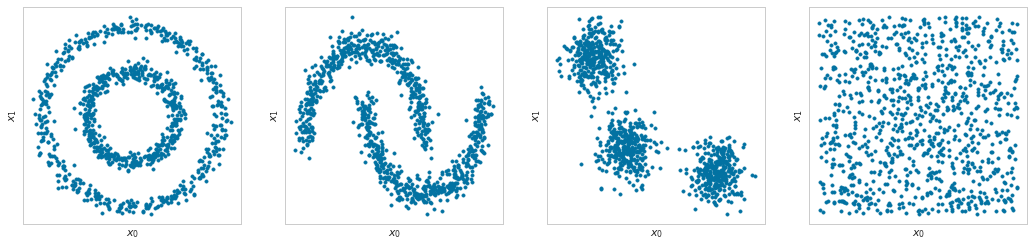

In [469]:
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

N = 1000 # Number of samples in each cluster

# Some colors for later
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

circles = make_circles(n_samples=N, factor=.5, noise=.05)
moons   = make_moons(n_samples=N, noise=.08)
blobs   = make_blobs(n_samples=N, random_state=9)
noise   = np.random.rand(N, 2), None

# Let's see what the data looks like!
fig, axe = plt.subplots(figsize=(18, 4))
for idx, dataset in enumerate((circles, moons, blobs, noise)):
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    
    plt.subplot(1,4,idx+1)
    plt.scatter(X[:,0], X[:,1], marker='.')

    plt.xticks(())
    plt.yticks(())
    plt.ylabel('$x_1$')
    plt.xlabel('$x_0$')

plt.show()

K-Means Clustering

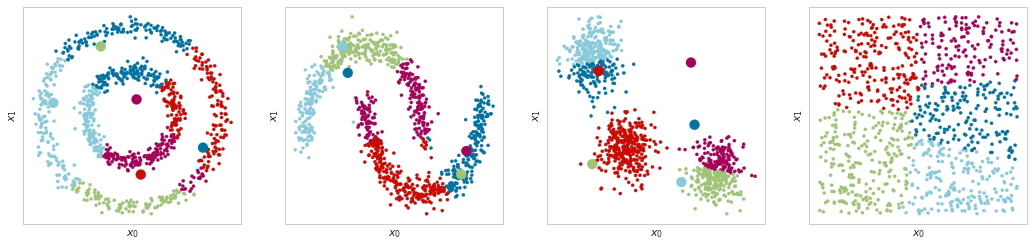

In [470]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import MiniBatchKMeans

fig, axe = plt.subplots(figsize=(18, 4))
for idx, dataset in enumerate((circles, moons, blobs, noise)):
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    
    # Fit the model with our algorithm
    model = MiniBatchKMeans(n_clusters=5)
    model.fit(X)
    
    # Make Predictions
    predictions = model.predict(X)
    
    # Find centers
    centers = model.cluster_centers_
    center_colors = colors[:len(centers)]
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
    
    plt.subplot(1,4,idx+1)
    plt.scatter(X[:, 0], X[:, 1], color=colors[predictions].tolist(), s=10)

    plt.xticks(())
    plt.yticks(())
    plt.ylabel('$x_1$')
    plt.xlabel('$x_0$')

plt.show()

Affinity Propagation

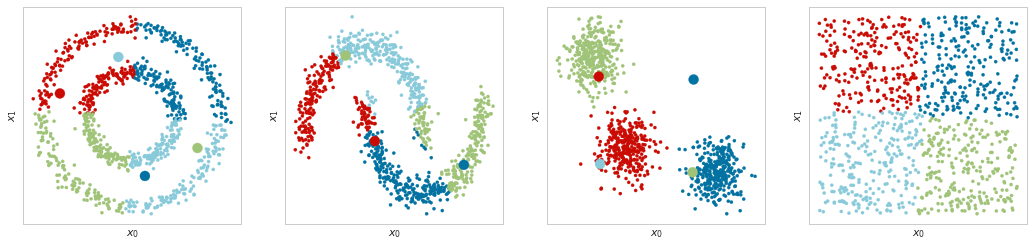

In [471]:
from sklearn.cluster import AffinityPropagation

fig, axe = plt.subplots(figsize=(18, 4))
for idx, dataset in enumerate((circles, moons, blobs, noise)):
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    
    # Fit the model with our algorithm
    model = AffinityPropagation(damping=.92, preference=-200)
    model.fit(X)
    
    # Make Predictions
    predictions = model.predict(X)
    
    # Find centers
    centers = model.cluster_centers_
    center_colors = colors[:len(centers)]
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
    
    plt.subplot(1,4,idx+1)
    plt.scatter(X[:, 0], X[:, 1], color=colors[predictions].tolist(), s=10)

    plt.xticks(())
    plt.yticks(())
    plt.ylabel('$x_1$')
    plt.xlabel('$x_0$')

plt.show()

# Yellow Brick for Republicans

In [472]:
Rep.columns

Index(['cand_id', 'cycle', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'c9', 'c10', 'c11', 'c12', 'c13', 'state_abbreviation', 'district',
       'incumbent', 'party', 'primary_votes', 'runoff_votes', 'general_votes',
       'ge_runoff_election_votes', 'winner', 'total_votes', 'totalspend',
       'costvote', 'race'],
      dtype='object')

In [473]:
features = Rep[[
   'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','c13'
]]

X = features

y = Rep['winner']

print(X.shape)
print(y.shape)

(4616, 13)
(4616,)


In [474]:
list(features)

['c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c9',
 'c10',
 'c11',
 'c12',
 'c13']

In [475]:
#Creating the test and train with sample size of 40%
from sklearn.model_selection import train_test_split as tts 
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25)

In [476]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3462, 13), (1154, 13), (3462,), (1154,))

             precision    recall  f1-score   support

          0       0.94      0.81      0.87       816
          1       0.65      0.87      0.74       338

avg / total       0.85      0.82      0.83      1154



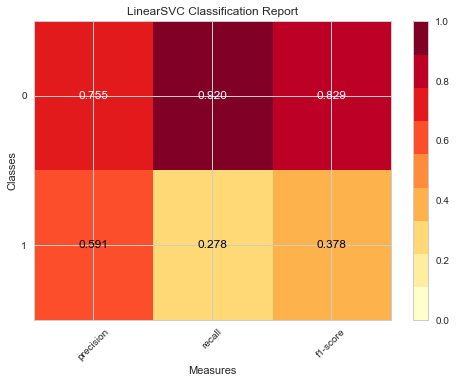

In [477]:
from sklearn.svm import LinearSVC

model = LinearSVC() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()             

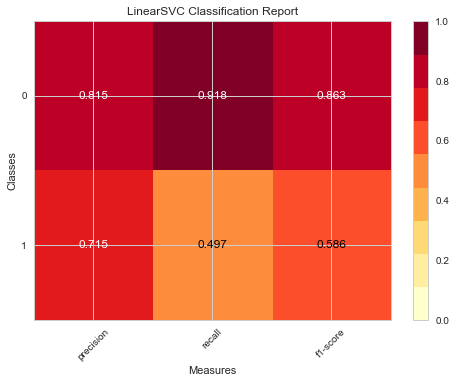

In [478]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

             precision    recall  f1-score   support

          0       0.71      1.00      0.83       816
          1       0.00      0.00      0.00       338

avg / total       0.50      0.71      0.58      1154



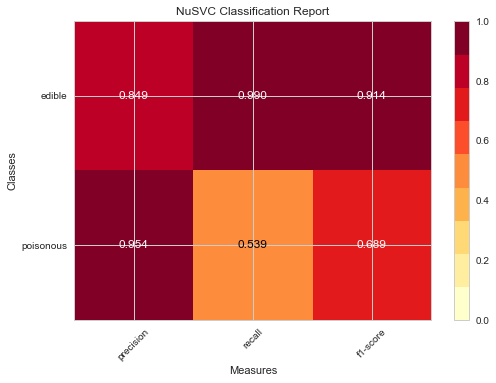

In [479]:
from sklearn.svm import NuSVC

model = NuSVC() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

visual_model_selection(X, y, NuSVC())

# Yellow Brick for Democrats

In [480]:
features = Dem[[
   'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','c13'
]]

X = features

y = Dem['winner']

print(X.shape)
print(y.shape)

(4029, 13)
(4029,)


In [481]:
from sklearn.model_selection import train_test_split as tts 
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25)

In [482]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3021, 13), (1008, 13), (3021,), (1008,))

             precision    recall  f1-score   support

          0       0.93      0.82      0.87       712
          1       0.66      0.84      0.74       296

avg / total       0.85      0.83      0.83      1008



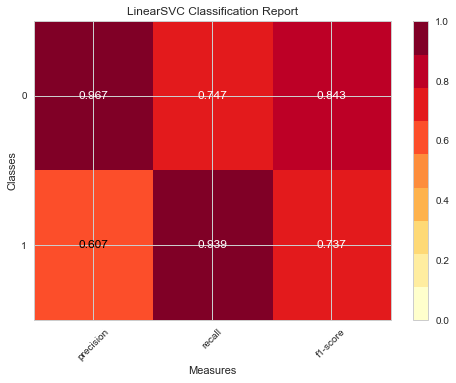

In [483]:
from sklearn.svm import LinearSVC

model = LinearSVC() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof() 

# Modeling and Evaluation

In [484]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        
        return output

In [485]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline


def model_selection(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())), 
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return the F1 score (the harmonic mean of precision and recall)
    return (f1_score(expected, predicted))

In [486]:
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [487]:
model_selection(X, y, LinearSVC())

0.99581939799331098

In [488]:
model_selection(X, y, NuSVC())

0.81117927743694618

In [489]:
model_selection(X, y, SVC())

0.0

In [490]:
model_selection(X, y, SGDClassifier())

0.98306519898391187

In [491]:
model_selection(X, y, KNeighborsClassifier())

0.098514464425332293

In [492]:
model_selection(X, y, LogisticRegressionCV())

0.0

In [493]:
model_selection(X, y, LogisticRegression())

0.98523829607760438

In [494]:
model_selection(X, y, BaggingClassifier())

0.9411262798634813

In [495]:
model_selection(X, y, ExtraTreesClassifier())

0.995798319327731

In [496]:
model_selection(X, y, RandomForestClassifier())

0.95196506550218352

# Regularization by Winning Indicator


In [497]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.1)
model.fit(X, y)

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

Mean Squared Error: 0.160
Coefficient of Determination: 0.234


In [498]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1)
model.fit(X, y)

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

Mean Squared Error: 0.160
Coefficient of Determination: 0.234
